The following notebook goes through 2 topics. The first one goes into details on how RASCAL works, the details of Hough Transform should be referred to the other Notebook in the same folder. The second one shows how user can perform wavelength calibration with the top level functions provided.

In [1]:
import sys
sys.path.append("..")

import matplotlib
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

from rascal.calibrator import Calibrator
from rascal import models

/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
params = {'legend.fontsize': 20,
          'figure.figsize': (10,10),
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'axes.titlepad': 28}
plt.rcParams.update(params)

## 1. Disecting RASCAL step-by-step

This notebook highlights how certain aspects of RASCAL work. Let's load some manually identified peaks:

In [4]:
peaks, wavelengths, lamps = np.loadtxt("data_lt_sprat/ground_truth_v_a.csv", delimiter=',', dtype='U').T

peaks = peaks.astype('float32')
wavelengths = wavelengths.astype('float32')
lamps = np.unique(lamps)

In [5]:
for p, w in zip(peaks, wavelengths):
    print("Pixel position and Best-fit wavelength of the peaks:  " + str(int(p)) + ' matched to ' + str(w))

Pixel position and Best-fit wavelength of the peaks:  241 matched to 4500.98
Pixel position and Best-fit wavelength of the peaks:  247 matched to 4524.68
Pixel position and Best-fit wavelength of the peaks:  260 matched to 4582.75
Pixel position and Best-fit wavelength of the peaks:  269 matched to 4624.28
Pixel position and Best-fit wavelength of the peaks:  280 matched to 4671.23
Pixel position and Best-fit wavelength of the peaks:  285 matched to 4697.02
Pixel position and Best-fit wavelength of the peaks:  294 matched to 4734.15
Pixel position and Best-fit wavelength of the peaks:  310 matched to 4807.02
Pixel position and Best-fit wavelength of the peaks:  335 matched to 4921.48
Pixel position and Best-fit wavelength of the peaks:  359 matched to 5028.28
Pixel position and Best-fit wavelength of the peaks:  462 matched to 5496.07
Pixel position and Best-fit wavelength of the peaks:  468 matched to 5531.07
Pixel position and Best-fit wavelength of the peaks:  477 matched to 5566.62

Now we instantiate a calibrator. In this case, we know that our wavelength range is around 3400 to 8000 Angstrom.

In [6]:
c = Calibrator(peaks, num_pixels=1024, min_wavelength=3400., max_wavelength=8000.)
c.add_atlas(elements=lamps)

Get the true linear fit

In [7]:
c_true, m_true = models.robust_polyfit(peaks, wavelengths, 1)
print('Gradient = ' + str(m_true) + ' and intercept = ' + str(c_true))

Gradient = 4.701520828155082 and intercept = 3344.365518951962


RASCAL begins by enumerating all possible peak/emission line pairs (blue points). Here we've overlaid the true fit with a black line and the individual solution with red stars.

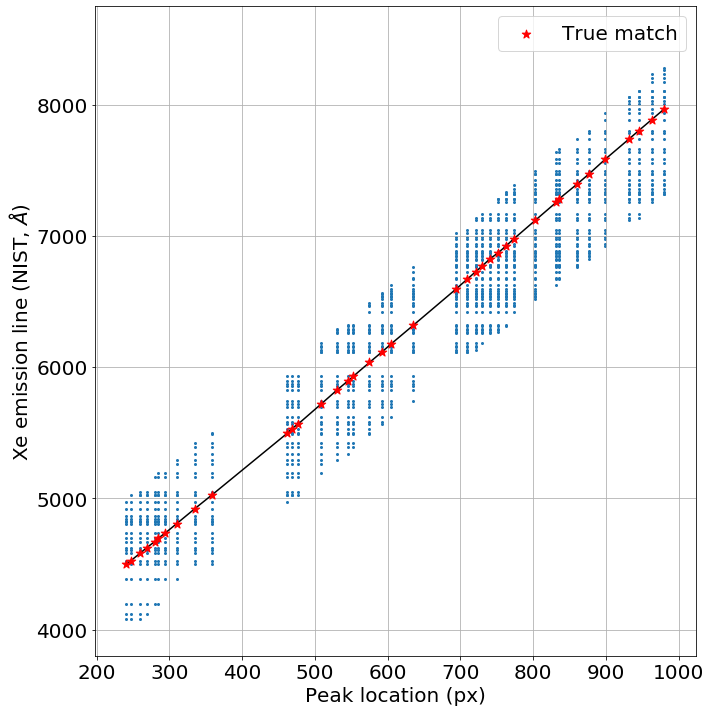

In [8]:
# Set the plotting space
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot
ax.scatter(*c.pairs.T, s=4)
ax.scatter(peaks, wavelengths, c='red', s=80, marker='*', label="True match", zorder=20)
ax.plot(peaks, wavelengths, c='black', zorder=10)

# Set the format
plt.xlabel("Peak location (px)")
plt.ylabel("Xe emission line (NIST, $\AA$)")
plt.ylim(3800,8750)
plt.grid()
plt.legend()
plt.tight_layout()

Next we run the Hough Transform and find the intersection with the highest density of potential solutions.

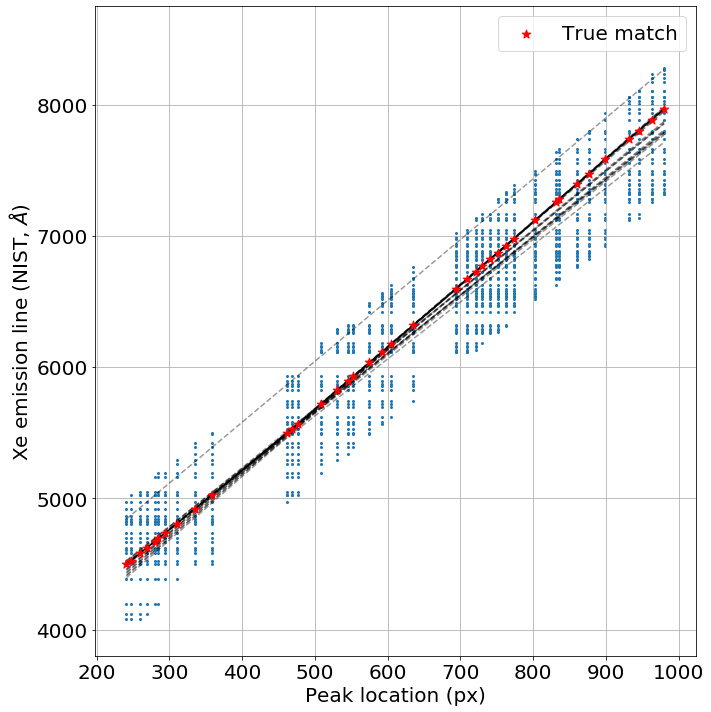

In [9]:
# Apply the Hough Transform
accumulator = c._hough_points(c.pairs[:,0], c.pairs[:,1], num_slopes=5000)
# Get the best potential solutions
_, lines = c._get_top_lines(accumulator, top_n=20, xbins=100, ybins=100)

x = np.linspace(min(peaks), max(peaks))

# Set the plotting space
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot
ax.scatter(*c.pairs.T, s=4)
ax.scatter(peaks, wavelengths, c='red', s=80, marker='*', label="True match", zorder=20)
ax.plot(peaks, wavelengths, c='black', zorder=10)

for l in lines:
    candidate_peaks, candidate_wavelengths = c._get_candidate_points_linear(l[0], l[1], thresh=15)
    f = models.polynomial(l, degree=1)
    ax.plot(x, f(x), alpha=0.4, c='black', linestyle='dashed')

# Set the format
ax.set_xlabel("Peak location (px)")
ax.set_ylabel("Xe emission line (NIST, $\AA$)")
ax.set_ylim(3800,8750)
ax.grid()
ax.legend()

fig.tight_layout()


The accumulator constructs 2D histrogram with square bins. However, for visualisation purpose, hexagonal bin can show the density variation more clearly to naked eyes.  

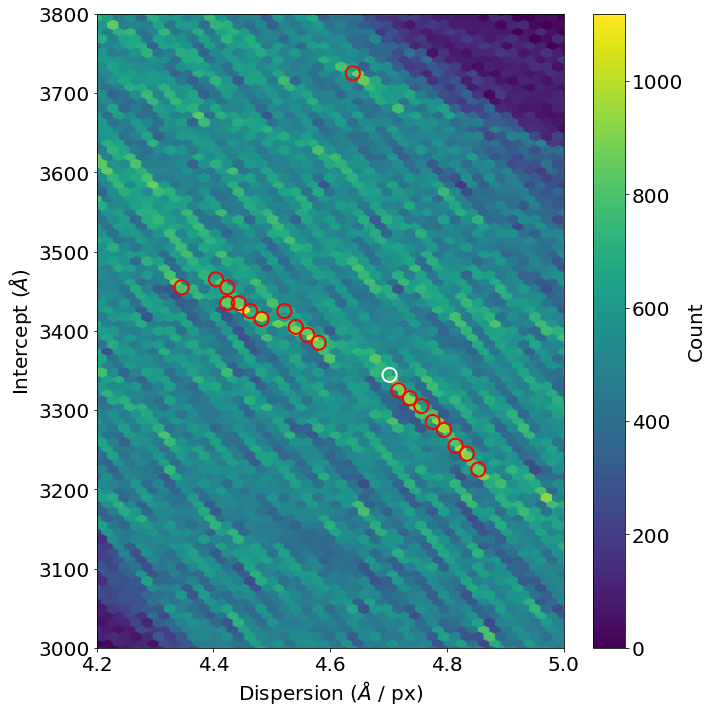

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Generate hex-plot
hexplot = ax.hexbin(*accumulator.T, gridsize=100)

# Add circles
for l in lines:
    ax.scatter(l[0], l[1], s=200, edgecolors='red', facecolors='None', linewidths=2)

ax.scatter(m_true, c_true, s=200, edgecolors='white', facecolors='None', linewidths=2)

# Add colour bar
cb = fig.colorbar(hexplot)
cb.set_label("Count")

# Set the format
ax.set_xlabel("Dispersion ($\AA$ / px)")
ax.set_ylabel("Intercept ($\AA$)")
ax.set_xlim(4.2, 5.)
ax.set_ylim(3000., 3800.)
fig.tight_layout()

The white circle is the true linear fit, whilst the red circles are the top 20 peaks in the histogram.


We can look at those lines and which peak/emission line pairs they correspond to. We set the threshold to be quite low, 15A to only get points which are in strong agreement (thresh=15).

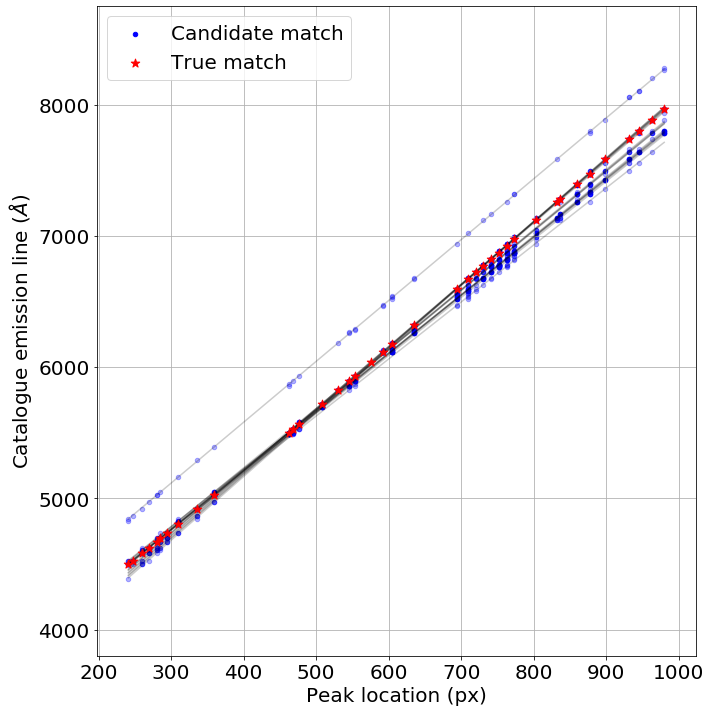

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

i = 0
for l in lines:
    #title("{} {}".format(*l))
    candidate_peaks, candidate_wavelengths = c._get_candidate_points_linear(l[0], l[1], thresh=15)
    f = models.polynomial(l, degree=1)
    ax.plot(x, f(x), alpha=0.2, c='black')
    
    if i==0:
        ax.scatter(candidate_peaks, candidate_wavelengths, c='blue', s=20, label="Candidate match", alpha=1)
        i = 1
    else:
        ax.scatter(candidate_peaks, candidate_wavelengths, c='blue', s=20, alpha=0.3)
    
ax.scatter(peaks, wavelengths, c='red', s=80, marker='*', label="True match", zorder=20)
    
# Set the format
ax.set_xlabel("Peak location (px)", fontsize=20)
ax.set_ylabel("Catalogue emission line ($\AA$)", fontsize=20)
ax.set_ylim(3800,8750)
ax.legend()
ax.grid()
fig.tight_layout()

The red circles here are the true matches. You see that there's a heavy black line running through them. That particular line is not straight, it's actually two clusters of straight lines which are tracing out a parabola. What's going on here?

There are a family of lines which match the peaks at 200-400px and a group which matches the peaks at 700-1000px. It's easier to see on separate curves:

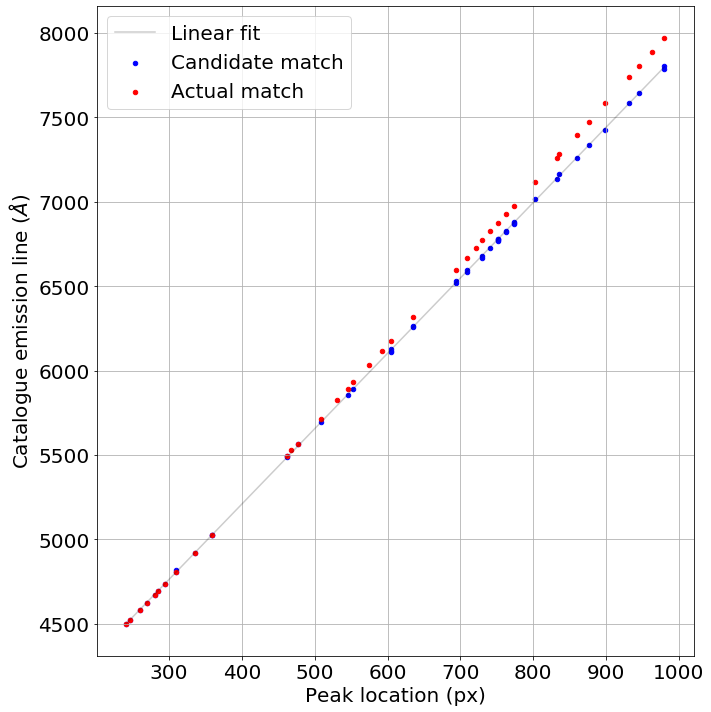

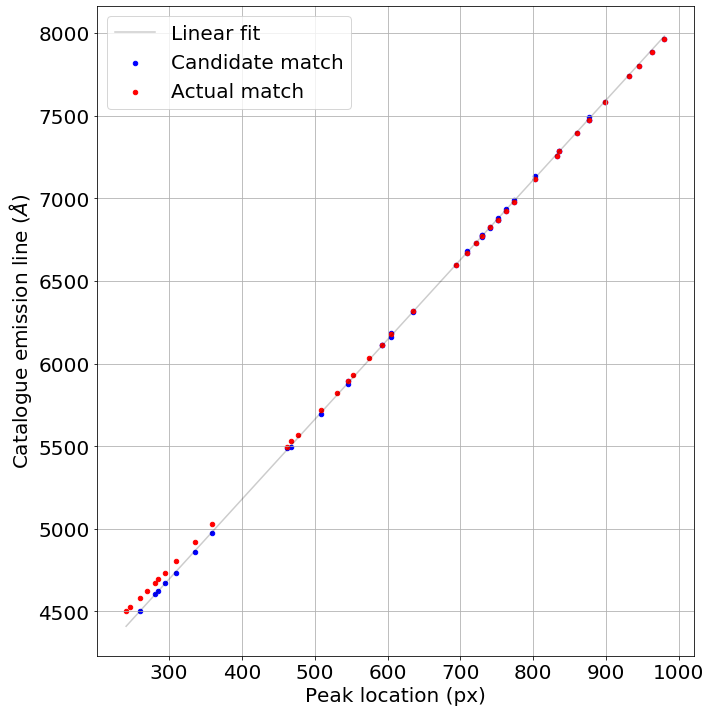

In [12]:
for i, l in enumerate([lines[0], lines[13]]):
    candidate_peaks, candidate_wavelengths = c._get_candidate_points_linear(l[0], l[1], thresh=15)

    fig = plt.figure(i, figsize=(10,10))
    ax = fig.add_subplot(111)

    f = models.polynomial(l, degree=1)
    ax.plot(x, f(x), alpha=0.2, c='black', label="Linear fit")
    
    ax.scatter(candidate_peaks, candidate_wavelengths, c='blue', s=20, label="Candidate match")
    ax.scatter(peaks, wavelengths, c='red',s=20, label="Actual match")

    ax.set_xlabel("Peak location (px)")
    ax.set_ylabel("Catalogue emission line ($\AA$)")
    ax.grid()
    ax.legend()
    fig.tight_layout()

RASCAL tries to take advantage of this by combining the information from all the top lines. For each linear fit, we go through all the peaks and add the closest matching wavelength. We combine all these points into one big list and we pick the peak/wavelength pairs that are the most common. What we end up is something like this:

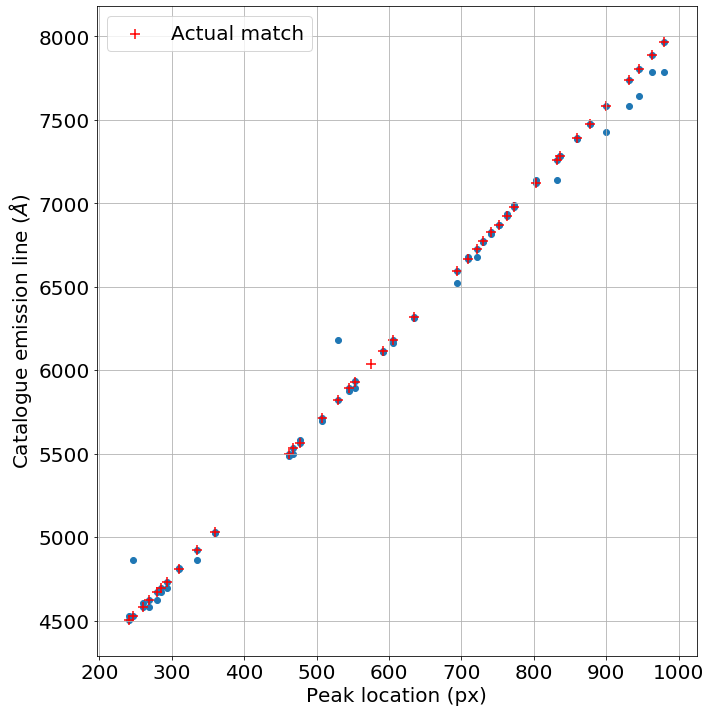

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
candidates = [c._get_candidate_points_linear(l[0], l[1], thresh=15) for l in lines]
out_p, out_w = c._combine_linear_estimates(candidates)

ax.scatter(out_p, out_w)
ax.scatter(peaks, wavelengths, c='red', s=100, marker='+', label="Actual match")
ax.set_xlabel("Peak location (px)")
ax.set_ylabel("Catalogue emission line ($\AA$)")
ax.grid()
ax.legend()
fig.tight_layout()

By combining the information from separate lines, we've managed to extract all the correct points pretty much perfectly. In real life we would probably have noisier peak extraction, but this shows the sorts of results you can get. Now we just run RANSAC.

In [14]:
_, lines = c._get_top_lines(accumulator, top_n=20, xbins=100, ybins=100)
candidates = [((l[0], l[1]), c._get_candidate_points_linear(l[0], l[1], thresh=20)) for l in lines]

In [15]:
p_coeff, _, _, _, _ = c._solve_candidate_ransac(x=out_p, y=out_w, thresh=7, max_tries=1e4, coeff=None, progress=True)

And we can compare our fit values to the actual ones; the residuals are very small.

In [16]:
x = peaks
y = np.polynomial.polynomial.polyval(peaks, p_coeff)

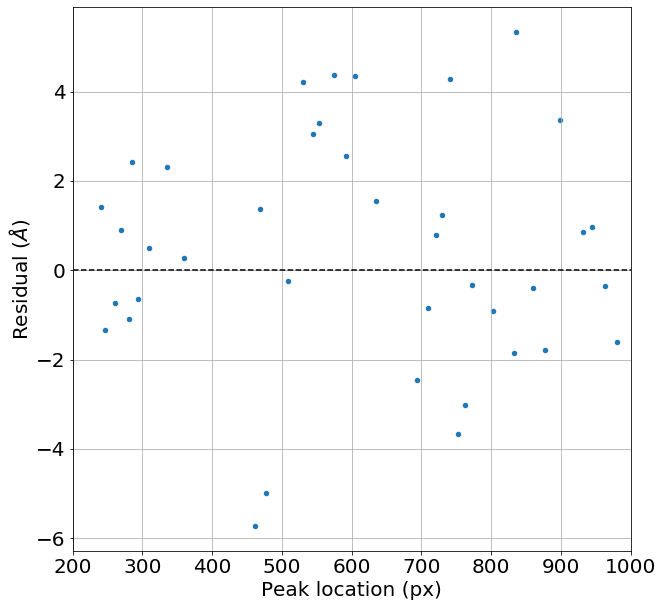

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(peaks, wavelengths-y, s=20)
ax.hlines(0, xmin=200, xmax=1000, ls="--")
ax.set_xlim(200, 1000)
ax.set_xlabel("Peak location (px)")
ax.set_ylabel("Residual ($\AA$)")
ax.grid()


The pixel scale of the example is 9.2 A per pixel, so the peak-to-peak residual is roughly 1 pixel.

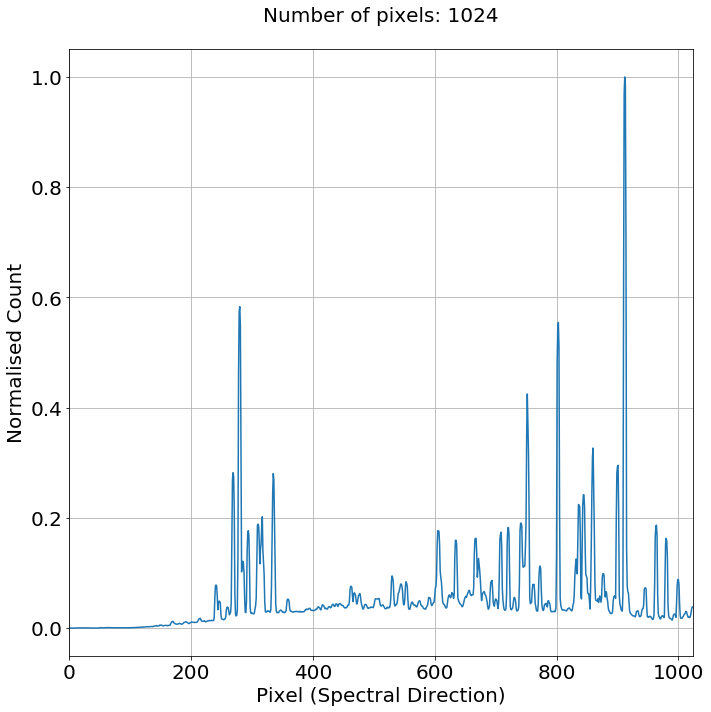

In [18]:
spectrum = np.median(fits.open('data_lt_sprat/v_a_20190516_55_1_0_1.fits')[0].data[110:120], axis=0)
peaks, _ = find_peaks(spectrum, height=500, distance=5, threshold=None)

plt.figure()
plt.plot(spectrum/spectrum.max())
plt.title('Number of pixels: ' + str(spectrum.shape[0]))
plt.xlabel("Pixel (Spectral Direction)")
plt.ylabel("Normalised Count")
plt.xlim(0,1024)
plt.grid()
plt.tight_layout()

/Users/marcolam/git/rascal/rascal/calibrator.py:1122: RuntimeWarning: divide by zero encountered in log10
  spectrum = np.log10(spectrum)


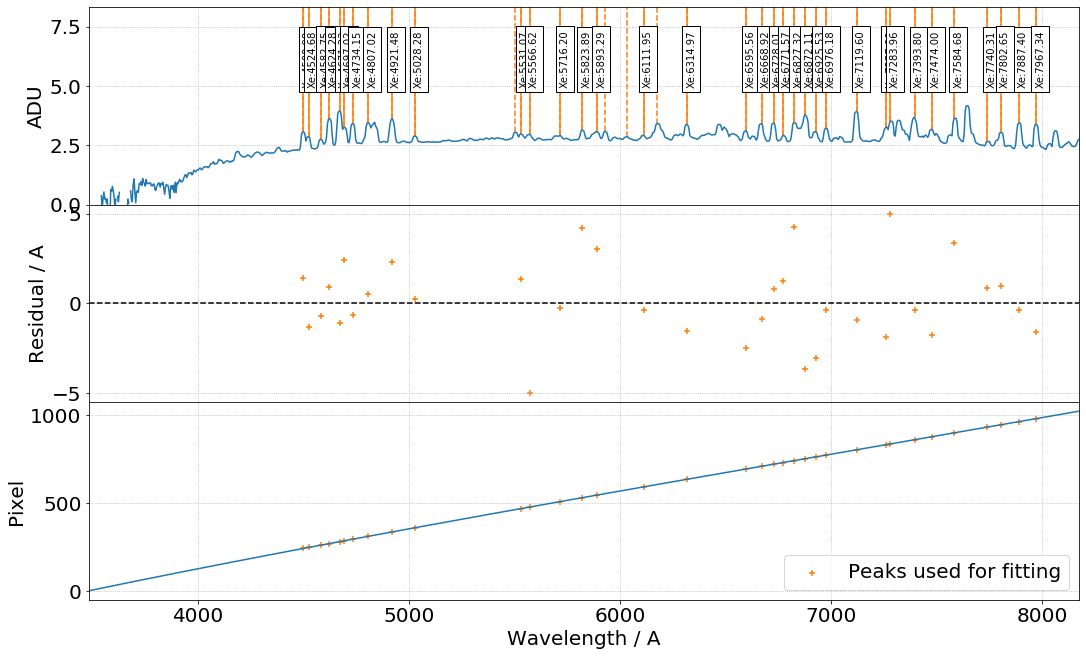

In [19]:
c.plot_fit(spectrum, p_coeff, plot_atlas=False)

## 2. Using top-level functions in real-life

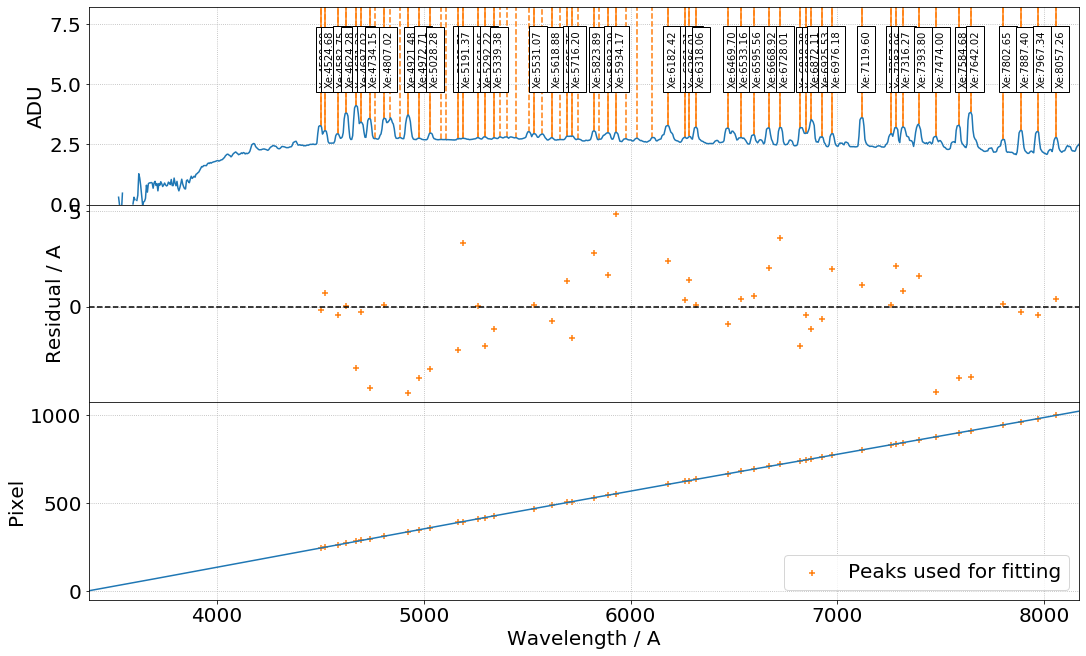

In [20]:
# Open a different Arc file taken on the same night
spectrum_actual = np.median(fits.open('data_lt_sprat/v_a_20190516_57_1_0_1.fits')[0].data[110:120], axis=0)
peaks_actual, _ = find_peaks(spectrum_actual, height=500, distance=5, threshold=None)

c_actual = Calibrator(peaks_actual, num_pixels=1024, min_wavelength=3800., max_wavelength=8200.)
c_actual.set_fit_constraints(num_slopes=5000, top_n_matches=5, range_tolerance=500., xbins=100, ybins=100)
c_actual.add_atlas(elements=lamps)

p_coeff_actual, _, _, _ = c_actual.fit(max_tries=1e4)
c_actual.plot_fit(spectrum_actual, p_coeff_actual, plot_atlas=False)